In [1]:
!pip install --no-cache-dir transformers huggingface_hub==0.27.0 datasets accelerate

INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 213.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 224.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 238.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 96.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 295.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 255.5 MB/s eta 0:00:00
INFO: pip is still looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 276.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0

In [2]:
# Standard library
import json
from time import sleep
from collections import Counter

# Third-party
import numpy as np
import requests
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.metrics import (
    classification_report,
    f1_score,
    hamming_loss,
    accuracy_score
)

# HuggingFace / Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    RobertaForSequenceClassification
)

# Datasets
from datasets import load_dataset, Dataset

2025-11-29 03:32:02.724822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764387123.097299      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764387123.220922      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
ds = load_dataset("lex_glue", "eurlex")

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/167M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/24.3M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/55000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [4]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 55000
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 5000
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 5000
    })
})


In [5]:
example = ds["train"][0]
example

{'text': 'COUNCIL DECISION\nof 7 June 2005\nabrogating Decision 2005/136/EC on the existence of an excessive deficit in the Netherlands\n(2005/729/EC)\nTHE COUNCIL OF THE EUROPEAN UNION,\nHaving regard to the Treaty establishing the European Community, and in particular Article 104(12) thereof,\nHaving regard to the recommendation from the Commission,\nWhereas:\n(1)\nBy Decision 2005/136/EC (1) following a recommendation from the Commission in accordance with Article 104(6) of the Treaty, the Council decided that an excessive deficit existed in the Netherlands.\n(2)\nIn accordance with Article 104(7) of the Treaty, the Council made a Recommendation on 2 June 2004 addressed to the Netherlands with a view to bringing the excessive deficit situation to an end. This Recommendation, in conjunction with Article 3(4) of Council Regulation (EC) No 1467/97 of 7 July 1997 on speeding up and clarifying the implementation of the excessive deficit procedure (2), established a deadline of 2005 at th

In [6]:
label2name = ds["train"].features["labels"].feature.names

c=0
for i, name in enumerate(label2name):
    if not c==5:
        print(i, name)
    else:
        break
    c+=1

0 100163
1 100168
2 100169
3 100170
4 100171


In [7]:
#---------------------------Fetch label from EuroVoc SPARQL endpoint------------------------------------------
def get_eurovoc_label(concept_id):
    """Fetch label from EuroVoc SPARQL endpoint"""
    sparql_endpoint = "http://publications.europa.eu/webapi/rdf/sparql"
    
    query = f"""
    PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
    SELECT ?label
    WHERE {{
      <http://eurovoc.europa.eu/{concept_id}> skos:prefLabel ?label .
      FILTER(lang(?label) = 'en')
    }}
    """
    
    try:
        response = requests.get(
            sparql_endpoint,
            params={'query': query, 'format': 'json'},
            timeout=10
        )
        if response.status_code == 200:
            data = response.json()
            if data['results']['bindings']:
                return data['results']['bindings'][0]['label']['value']
    except Exception as e:
        print(f"Error for {concept_id}: {e}")
    
    return concept_id

# Build mapping with rate limiting
label2description = {}
for i, concept_id in enumerate(label2name):
    label2description[concept_id] = get_eurovoc_label(concept_id)
    print(f"{concept_id}: {label2description[concept_id]}")
    if i % 10 == 0:  # Add delay every 10 requests
        sleep(1)

100163: 0406 political framework
100168: 0431 politics and public safety
100169: 0436 executive power and public service
100170: 0806 international affairs
100171: 0811 cooperation policy
100172: 0816 international security
100173: 0821 defence
100174: 1006 EU institutions and European civil service
100175: 1011 European Union law
100176: 1016 European construction
100177: 1021 EU finance
100179: 1211 civil law
100180: 1216 criminal law
100183: 1231 international law
100184: 1236 rights and freedoms
100185: 1606 economic policy
100186: 1611 economic conditions
100187: 1616 regions and regional policy
100189: 1626 national accounts
100190: 1631 economic analysis
100191: 2006 trade policy
100192: 2011 tariff policy
100193: 2016 trade
100194: 2021 international trade
100195: 2026 consumption
100196: 2031 marketing
100197: 2036 distributive trades
100198: 2406 monetary relations
100199: 2411 monetary economics
100200: 2416 financial institutions and credit
100201: 2421 free movement of cap

In [8]:
len(label2description)

100

In [9]:
#---------------------------High-level category aggregation for EuroVoc classes------------------------------------------
high_level_categories = {
    "Politics & Government": {
        "100163", "100168", "100169", "100174", "100175", "100176", "100177"
    },
    
    "International Affairs & Defense": {
        "100170", "100171", "100172", "100173", "100183", "100285"
    },
    
    "Law & Justice": {
        "100179", "100180", "100184"
    },
    
    "Economics & Finance": {
        "100185", "100186", "100189", "100190", "100198", "100199", "100200", 
        "100201", "100202", "100204", "100205", "100206", "100207"
    },
    
    "Trade & Business": {
        "100191", "100192", "100193", "100194", "100195", "100196", "100197",
        "100226", "100227", "100229", "100230", "100231"
    },
    
    "Employment & Labor": {
        "100232", "100233", "100234", "100235"
    },
    
    "Social Affairs & Health": {
        "100212", "100214", "100215"
    },
    
    "Technology & Science": {
        "100220", "100221", "100222", "100223", "100224", "100261", "100262"
    },
    
    "Transportation": {
        "100237", "100238", "100239", "100240", "100241"
    },
    
    "Environment": {
        "100242", "100243", "100244"
    },
    
    "Agriculture & Food": {
        "100245", "100246", "100247", "100248", "100249", "100250", "100252",
        "100253", "100254", "100255", "100256", "100257", "100258", "100259"
    },
    
    "Energy & Resources": {
        "100263", "100264", "100265", "100266"
    },
    
    "Industry & Manufacturing": {
        "100260", "100268", "100269", "100270", "100271", "100272", "100273",
        "100274", "100275", "100276"
    },
    
    "Geography & Regional": {
        "100187", "100277", "100278", "100279", "100280", "100281", "100282",
        "100283", "100284"
    },
}

# Verify all classes are mapped
all_mapped = set()
for classes in high_level_categories.values():
    all_mapped.update(classes)

all_labels = set(label2name)
unmapped = all_labels - all_mapped

print(f"Total labels: {len(all_labels)}")
print(f"Mapped labels: {len(all_mapped)}")
print(f"Unmapped labels: {unmapped if unmapped else 'None'}")

# Print the mapping
print("\n=== High-Level Category Mapping ===")
for category, classes in high_level_categories.items():
    print(f"\n{category}: {len(classes)} classes")
    for class_id in sorted(classes):
        print(f"  - {class_id}: {label2description.get(class_id, 'Unknown')}")

Total labels: 100
Mapped labels: 100
Unmapped labels: None

=== High-Level Category Mapping ===

Politics & Government: 7 classes
  - 100163: 0406 political framework
  - 100168: 0431 politics and public safety
  - 100169: 0436 executive power and public service
  - 100174: 1006 EU institutions and European civil service
  - 100175: 1011 European Union law
  - 100176: 1016 European construction
  - 100177: 1021 EU finance

International Affairs & Defense: 6 classes
  - 100170: 0806 international affairs
  - 100171: 0811 cooperation policy
  - 100172: 0816 international security
  - 100173: 0821 defence
  - 100183: 1231 international law
  - 100285: 7606 United Nations

Law & Justice: 3 classes
  - 100179: 1211 civil law
  - 100180: 1216 criminal law
  - 100184: 1236 rights and freedoms

Economics & Finance: 13 classes
  - 100185: 1606 economic policy
  - 100186: 1611 economic conditions
  - 100189: 1626 national accounts
  - 100190: 1631 economic analysis
  - 100198: 2406 monetary rela

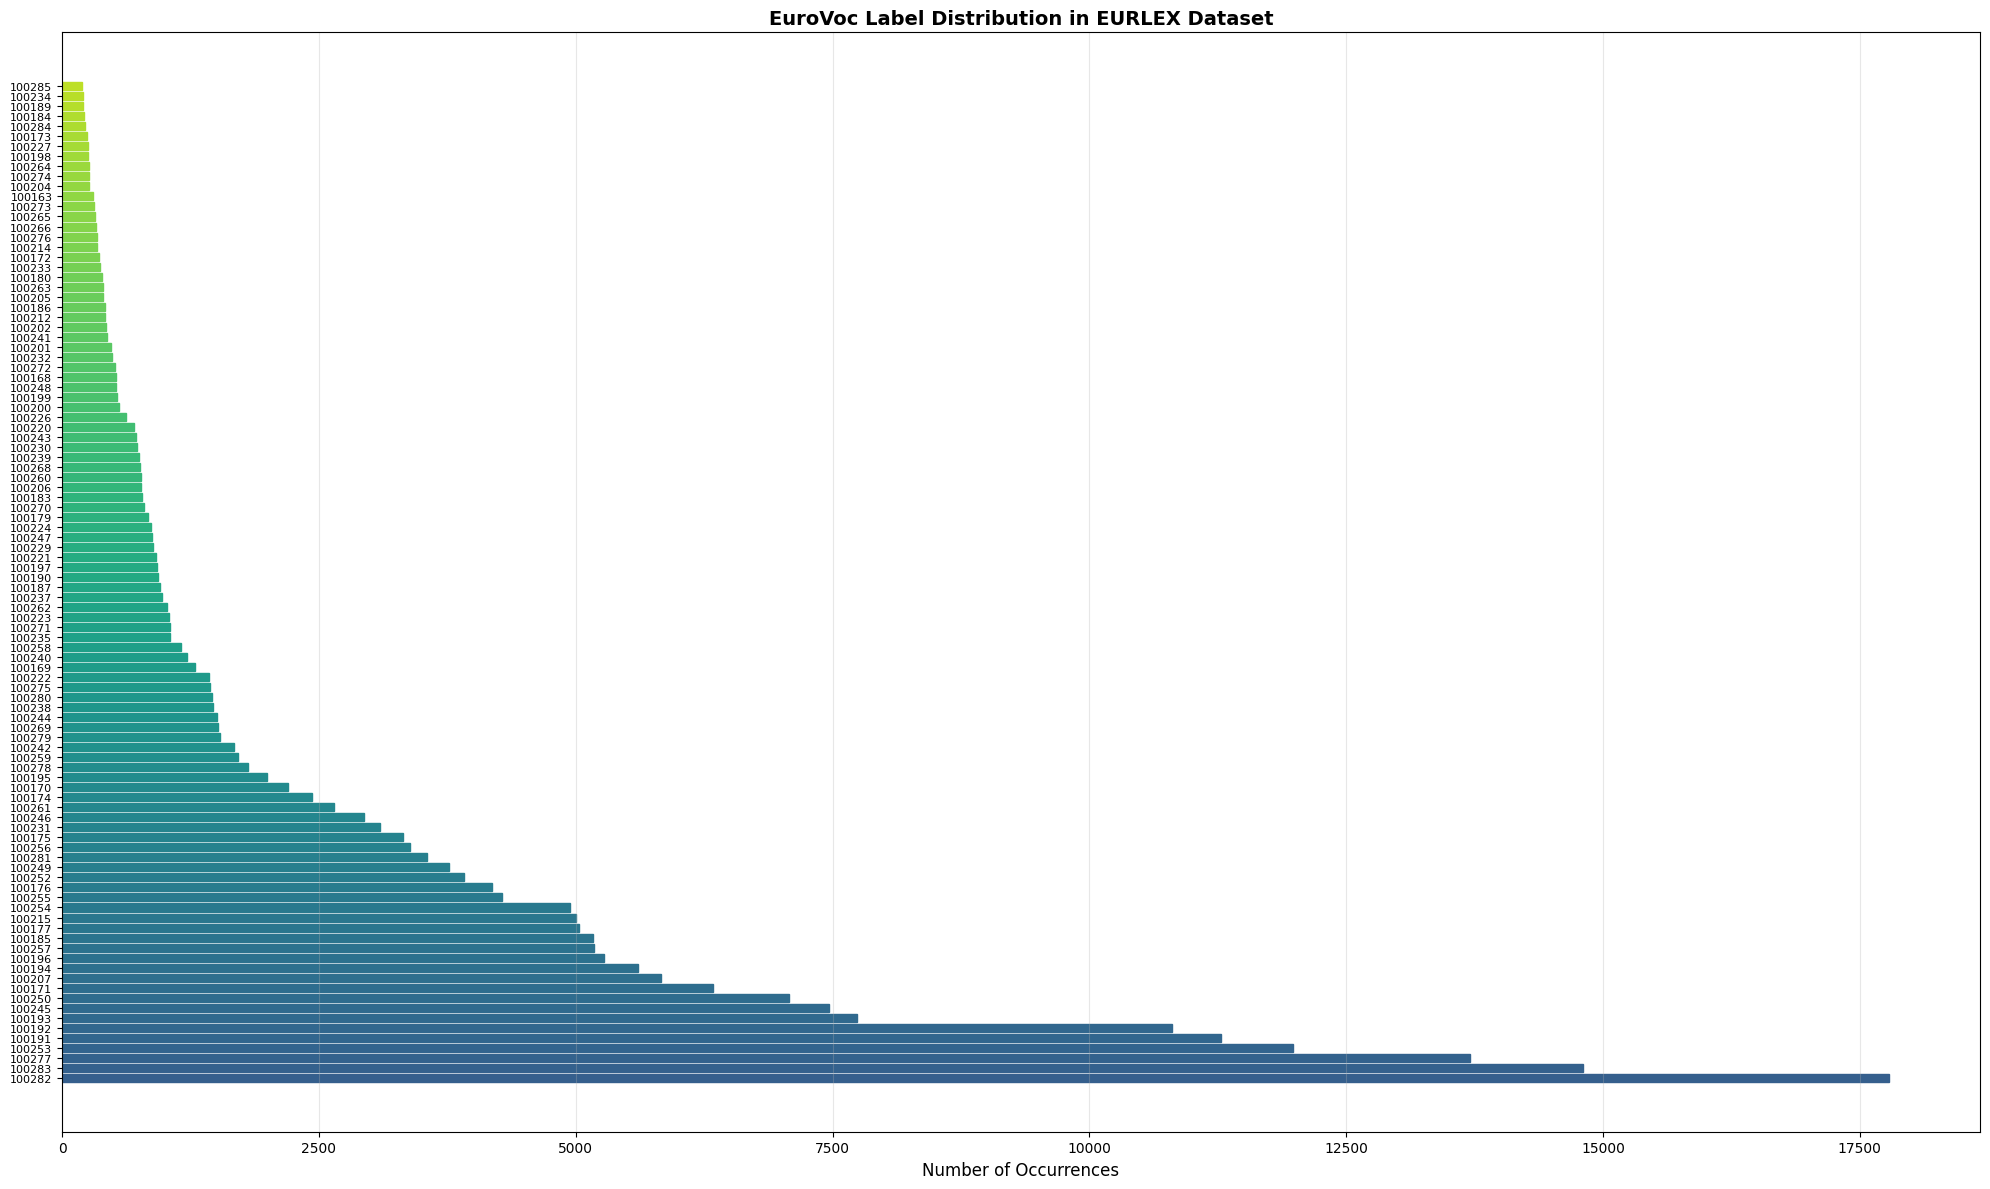


=== Dataset Statistics ===
Total examples: 55000
Total labels: 100
Total label occurrences: 243349
Average labels per document: 4.42

Top 10 most frequent labels:
  100282: 17781 (32.3%)
  100283: 14803 (26.9%)
  100277: 13702 (24.9%)
  100253: 11982 (21.8%)
  100191: 11277 (20.5%)
  100192: 10804 (19.6%)
  100193: 7739 (14.1%)
  100245: 7470 (13.6%)
  100250: 7072 (12.9%)
  100171: 6335 (11.5%)


In [10]:
#---------------------------labels occurence in the dataset------------------------------------------
# Count label occurrences (handling multi-label)
label_counts = Counter()

for example in ds["train"]:
    for label in example["labels"]:
        label_counts[label] += 1

# Get label names
label2name = ds["train"].features["labels"].feature.names

# Prepare data for plotting
labels = []
counts = []
for label_id, count in label_counts.most_common():
    label_name = label2name[label_id]
    labels.append(f"{label_name}")
    counts.append(count)

# Create the plot
plt.figure(figsize=(20, 12))
bars = plt.barh(range(len(labels)), counts)

# Color bars by frequency (darker = more frequent)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(labels)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.yticks(range(len(labels)), labels, fontsize=8)
plt.xlabel('Number of Occurrences', fontsize=12)
plt.title('EuroVoc Label Distribution in EURLEX Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.grid(axis='x', alpha=0.3)
plt.show()

# Print statistics
print(f"\n=== Dataset Statistics ===")
print(f"Total examples: {len(ds['train'])}")
print(f"Total labels: {len(label_counts)}")
print(f"Total label occurrences: {sum(label_counts.values())}")
print(f"Average labels per document: {sum(label_counts.values()) / len(ds['train']):.2f}")
print(f"\nTop 10 most frequent labels:")
for label_id, count in label_counts.most_common(10):
    label_name = label2name[label_id]
    print(f"  {label_name}: {count} ({count/len(ds['train'])*100:.1f}%)")

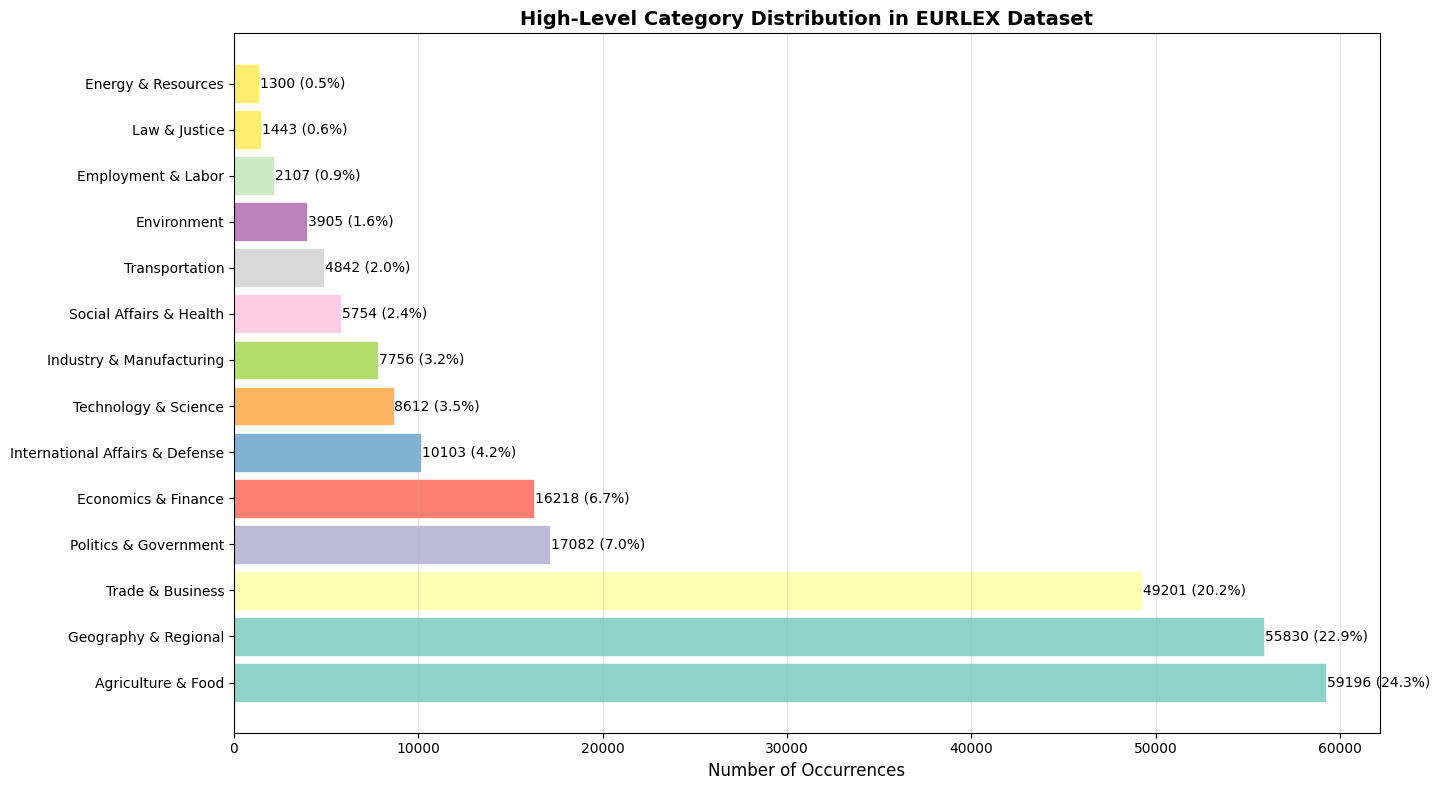

In [11]:
#------------------------------------------------------high level labels occurence in the dataset----------------------
# Create reverse mapping: label_id -> high_level_category
label_to_category = {}
for category, label_set in high_level_categories.items():
    for label_id in label_set:
        label_to_category[label_id] = category

# Count high-level category occurrences
category_counts = Counter()
for example in ds["train"]:
    for label_idx in example["labels"]:
        label_id = label2name[label_idx]
        category = label_to_category.get(label_id, "Other")
        category_counts[category] += 1

# Calculate total for percentages
total_count = sum(category_counts.values())

# Plot high-level categories
categories = [cat for cat, _ in category_counts.most_common()]
counts = [count for _, count in category_counts.most_common()]

plt.figure(figsize=(14, 8))
bars = plt.barh(categories, counts)

# Color bars
colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.xlabel('Number of Occurrences', fontsize=12)
plt.title('High-Level Category Distribution in EURLEX Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.grid(axis='x', alpha=0.3)

# Add count labels and percentages on bars
for i, (category, count) in enumerate(zip(categories, counts)):
    percentage = (count / total_count) * 100
    label = f'{count} ({percentage:.1f}%)'
    plt.text(count + 100, i, label, va='center', fontsize=10)

plt.show()

In [12]:
#------------------------------------------------------Create mappings----------------------
category_names = list(high_level_categories.keys())
category_to_id = {cat: idx for idx, cat in enumerate(category_names)}
id_to_category = {idx: cat for cat, idx in category_to_id.items()}

label_to_category_id = {}
for category, label_set in high_level_categories.items():
    for label_id in label_set:
        label_to_category_id[label_id] = category_to_id[category]

print(f"\nHigh-level categories: {len(category_names)}")
for cat in category_names:
    print(f"  - {cat}")


High-level categories: 14
  - Politics & Government
  - International Affairs & Defense
  - Law & Justice
  - Economics & Finance
  - Trade & Business
  - Employment & Labor
  - Social Affairs & Health
  - Technology & Science
  - Transportation
  - Environment
  - Agriculture & Food
  - Energy & Resources
  - Industry & Manufacturing
  - Geography & Regional


In [13]:
#------------------------------------------------------convert labels to multi-hot vector----------------------
def transform_to_multilabel(example):
    """Convert fine-grained labels into a multi-hot vector of high-level categories"""
    vector = np.zeros(len(category_names), dtype=int)
    for label_idx in example["labels"]:
        label_id = label2name[label_idx]
        if label_id in label_to_category_id:
            vector[label_to_category_id[label_id]] = 1
    return {"text": example["text"], "labels": vector.tolist()}

train_data = [transform_to_multilabel(ex) for ex in ds["train"]]
val_data = [transform_to_multilabel(ex) for ex in ds["validation"]]
test_data = [transform_to_multilabel(ex) for ex in ds["test"]]

In [14]:
print(f"\nDataset sizes after transformation:")
print(f"  Train: {len(train_data)}")
print(f"  Val: {len(val_data)}")
print(f"  Test: {len(test_data)}")


Dataset sizes after transformation:
  Train: 55000
  Val: 5000
  Test: 5000


In [15]:
#------------------------------------------------------Remove unmapped (-1 labels)----------------------
train_data = [ex for ex in train_data if ex["labels"] != -1]
val_data = [ex for ex in val_data if ex["labels"] != -1]
test_data = [ex for ex in test_data if ex["labels"] != -1]

print(f"\nDataset sizes after transformation:")
print(f"  Train: {len(train_data)}")
print(f"  Val: {len(val_data)}")
print(f"  Test: {len(test_data)}")


Dataset sizes after transformation:
  Train: 55000
  Val: 5000
  Test: 5000


In [16]:
# Count occurrences of each category across all documents
category_document_counts = Counter()

for ex in train_data:
    labels_array = ex["labels"]
    for idx, value in enumerate(labels_array):
        if value == 1:  # Only count when the label is present
            category_document_counts[idx] += 1

print("\n=== Multi-label Category Distribution (Documents) ===")
for label_id in sorted(category_document_counts.keys()):
    count = category_document_counts[label_id]
    category_name = id_to_category[label_id]
    percentage = (count / len(train_data)) * 100
    print(f"{category_name}: {count} documents ({percentage:.1f}%)")

print(f"\nTotal training documents: {len(train_data)}")

# Also check the structure of your labels
print("\n=== Label Structure Check ===")
print(f"Number of categories: {len(category_names)}")
print(f"Sample labels (first 5 documents):")
for i, ex in enumerate(train_data[:5]):
    active_categories = [id_to_category[idx] for idx, val in enumerate(ex["labels"]) if val == 1]
    print(f"  Doc {i}: {active_categories}")

# Verify label vector length
label_lengths = [len(ex["labels"]) for ex in train_data]
print(f"\nLabel vector lengths - Min: {min(label_lengths)}, Max: {max(label_lengths)}")
if len(set(label_lengths)) > 1:
    print("WARNING: Inconsistent label vector lengths!")


=== Multi-label Category Distribution (Documents) ===
Politics & Government: 14479 documents (26.3%)
International Affairs & Defense: 9165 documents (16.7%)
Law & Justice: 1318 documents (2.4%)
Economics & Finance: 14201 documents (25.8%)
Trade & Business: 33539 documents (61.0%)
Employment & Labor: 1854 documents (3.4%)
Social Affairs & Health: 5670 documents (10.3%)
Technology & Science: 7074 documents (12.9%)
Transportation: 3307 documents (6.0%)
Environment: 3104 documents (5.6%)
Agriculture & Food: 37255 documents (67.7%)
Energy & Resources: 1101 documents (2.0%)
Industry & Manufacturing: 6844 documents (12.4%)
Geography & Regional: 23346 documents (42.4%)

Total training documents: 55000

=== Label Structure Check ===
Number of categories: 14
Sample labels (first 5 documents):
  Doc 0: ['Economics & Finance', 'Geography & Regional']
  Doc 1: ['International Affairs & Defense', 'Trade & Business', 'Agriculture & Food']
  Doc 2: ['Politics & Government', 'Economics & Finance', 'Te

In [17]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [18]:
lengths = [len(sample["text"]) for sample in train_data]
import numpy as np
print(np.percentile(lengths, [50, 75, 90, 95, 99]))

# [ 2818.    5423.   12673.5  25835.8  78145.49], but roberta accepts only max 512 tokens so truncation isnt suffeicient, wll apply chunking 

[ 2818.    5423.   12673.5  25835.8  78145.49]


In [19]:
#------------------set roberta tokenizer------------------------------------
# Use ORIGINAL unbalanced data - no oversampling
train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(val_data)
test_dataset = Dataset.from_list(test_data)

def tokenize_function(examples):
    tokens = tokenizer(
        examples["text"], 
        padding="max_length", 
        truncation=True, 
        max_length=512
    )
    # Convert labels to float for BCEWithLogitsLoss
    tokens["labels"] = [[float(label) for label in labels] for labels in examples["labels"]]
    return tokens


## chunk text

In [20]:
def chunk_text(text, tokenizer, max_length=512, overlap=50):
    tokens = tokenizer(text, add_special_tokens=False)["input_ids"]

    chunks = []
    start = 0

    while start < len(tokens):
        end = start + (max_length - 2)  # reserve space for <s> and </s>

        chunk = tokens[start:end]

        chunks.append(chunk)

        start += max_length - overlap

    return chunks

from datasets import Dataset

def prepare_multichunk_dataset(data, tokenizer, max_length=512, overlap=50):
    new_data = []

    for sample in data:
        text = sample["text"]
        labels = [float(x) for x in sample["labels"]]


        # Generate chunks
        chunks = chunk_text(text, tokenizer, max_length=max_length, overlap=overlap)

        # Create one training example per chunk
        for chunk in chunks:
            chunk_with_special = [tokenizer.cls_token_id] + chunk + [tokenizer.sep_token_id]
        
            padded = chunk_with_special + [tokenizer.pad_token_id] * (max_length - len(chunk_with_special))
        
            attention_mask = [1] * len(chunk_with_special) + [0] * (max_length - len(chunk_with_special))
        
            new_data.append({
                "input_ids": padded,
                "attention_mask": attention_mask,
                "labels": labels
            })
        

    return Dataset.from_list(new_data)


# Re-map the datasets with the fixed function
train_dataset = prepare_multichunk_dataset(train_data, tokenizer)
val_dataset = prepare_multichunk_dataset(val_data, tokenizer)
test_dataset = prepare_multichunk_dataset(test_data, tokenizer)

# Set format for all datasets
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Token indices sequence length is longer than the specified maximum sequence length for this model (1001 > 512). Running this sequence through the model will result in indexing errors


In [21]:
lengths = [len(x["input_ids"]) for x in train_dataset]
print("Min length:", min(lengths))
print("Max length:", max(lengths))
print("Unique lengths:", set(lengths))

Min length: 512
Max length: 512
Unique lengths: {512}


In [22]:
def calculate_pos_weights(data, reduction_factor=0.5):
    """Calculate dampened positive class weights"""
    label_counts = np.zeros(len(category_names))
    total_docs = len(data)
    
    for ex in data:
        label_counts += np.array(ex["labels"], dtype=float)
    
    # Apply square root or power dampening
    pos_weights = (total_docs - label_counts) / (label_counts + 1e-5)
    
    # Dampen extreme weights
    pos_weights = pos_weights ** reduction_factor  # or use sqrt
    
    # Optional: clip maximum weight
    pos_weights = np.clip(pos_weights, 1.0, 10.0)
    
    return torch.tensor(pos_weights, dtype=torch.float32)

pos_weights = calculate_pos_weights(train_dataset, reduction_factor=0.5)
print("\nClass weights:")
for i, weight in enumerate(pos_weights):
    print(f"  {id_to_category[i]}: {weight:.2f}")


Class weights:
  Politics & Government: 1.53
  International Affairs & Defense: 2.37
  Law & Justice: 4.66
  Economics & Finance: 1.59
  Trade & Business: 1.00
  Employment & Labor: 5.03
  Social Affairs & Health: 2.88
  Technology & Science: 2.07
  Transportation: 3.31
  Environment: 3.66
  Agriculture & Food: 1.02
  Energy & Resources: 4.81
  Industry & Manufacturing: 1.96
  Geography & Regional: 1.12


In [23]:
#------------------------------------Define Train Arguments--------------------------------------
class CustomDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        batch = super().__call__(features)
        # Convert labels to float - use .float() not torch.tensor()
        if "labels" in batch:
            batch["labels"] = batch["labels"].float()
        return batch

data_collator = CustomDataCollator(tokenizer=tokenizer)

# Training arguments
training_args = TrainingArguments(
    output_dir="./eurlex_roberta_highlevel",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=6,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_steps=50,     
    report_to="none",    
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    logging_dir="./logs",
    fp16=True,
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [24]:
# =========================================================Metrics====================================================
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    preds = (probs > 0.5).astype(int)
    labels = labels.astype(int)

    # F1
    f1_macro = f1_score(labels, preds, average="macro", zero_division=0)
    f1_micro = f1_score(labels, preds, average="micro", zero_division=0)

    # Hamming loss
    h_loss = hamming_loss(labels, preds)

    # Subset accuracy (exact match)
    subset_acc = accuracy_score(labels, preds)

    # Normal multilabel accuracy = % of correct individual labels
    normal_accuracy = (preds == labels).mean()

    return {
        "f1_macro": f1_macro,
        "f1_micro": f1_micro,
        "hamming_loss": h_loss,
        "subset_accuracy": subset_acc,
        "normal_accuracy": normal_accuracy
    }


In [25]:
import os
import shutil

# Source folder inside the mounted input dataset
source_folder = "/kaggle/input/multi-label-news-classification-eurlex/eurlex_roberta_highlevel/checkpoint-33972"

# Destination folder inside working directory
dest_folder = "/kaggle/working/eurlex_roberta_highlevel/checkpoint-33972"

# Create destination folder
os.makedirs(dest_folder, exist_ok=True)

# List of files in the checkpoint
checkpoint_files = [
    "config.json",
    "merges.txt",
    "model.safetensors",
    "optimizer.pt",
    "rng_state.pth",
    "scaler.pt",
    "scheduler.pt",
    "special_tokens_map.json",
    "tokenizer_config.json",
    "tokenizer.json",
    "trainer_state.json",
    "training_args.bin",
    "vocab.json"
]

# Move files into the new folder
for f in checkpoint_files:
    shutil.copy(os.path.join(source_folder, f), os.path.join(dest_folder, f))

print("Checkpoint folder is ready at:", dest_folder)


Checkpoint folder is ready at: /kaggle/working/eurlex_roberta_highlevel/checkpoint-33972


In [26]:
# --------------------Load model--------------------------------------
print("\nLoading RoBERTa model...")
from transformers import AutoConfig

config = AutoConfig.from_pretrained(
    "roberta-base",
    num_labels=len(category_names),
    problem_type="multi_label_classification"
)

checkpoint_path = "/kaggle/working/eurlex_roberta_highlevel/checkpoint-33972"

print("Loading from checkpoint:", checkpoint_path)

model = RobertaForSequenceClassification.from_pretrained(
    checkpoint_path,
    local_files_only=True
)


Loading RoBERTa model...
Loading from checkpoint: /kaggle/working/eurlex_roberta_highlevel/checkpoint-33972


In [27]:
#-----------------------------customize training to class weighting loss-----------------------------
class WeightedBCETrainer(Trainer):
    def __init__(self, pos_weight=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos_weight = pos_weight
    
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        
        # Forward pass
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Move pos_weight to the same device as logits
        pos_weight = self.pos_weight.to(logits.device) if self.pos_weight is not None else None
        
        # Compute weighted BCE loss
        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        loss = loss_fct(logits, labels)
        
        return (loss, outputs) if return_outputs else loss

In [28]:
# ================== Test trainig on small subset of data ==================
test_train = False
if test_train:
    train_dataset_small = train_dataset.select(range(200))   
    val_dataset_small   = val_dataset.select(range(50))      
    val_dataset_small   = test_dataset.select(range(2))      

    
    # ========================================Train====================================================
    print("\n=== Starting Training ===")
    trainer = WeightedBCETrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset_small,
        eval_dataset=val_dataset_small,
        compute_metrics=compute_metrics,
        data_collator=data_collator,
        pos_weight=pos_weights
    )
    trainer.train() 

    # --------------------------------------Evaluate on test set====================================================
    print("\n=== Evaluating on Test Set ===")
    test_results = trainer.predict(val_dataset_small)
    probs = torch.sigmoid(torch.tensor(test_results.predictions)).numpy()
    predictions = (probs > 0.5).astype(int)  # Multi-label predictions
    labels = test_results.label_ids
    
    # -------------------------------------------------------Print classification report
    from sklearn.metrics import classification_report
    print("\nClassification Report:")
    print(classification_report(
        labels, 
        predictions, 
        target_names=category_names,
        digits=4
    ))

In [29]:
# ========================================Train====================================================
print("\n=== Starting Training ===")
trainer = WeightedBCETrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    pos_weight=pos_weights
)

trainer.train(resume_from_checkpoint=checkpoint_path)


=== Starting Training ===


Epoch,Training Loss,Validation Loss,F1 Macro,F1 Micro,Hamming Loss,Subset Accuracy,Normal Accuracy,Runtime,Samples Per Second,Steps Per Second
3,0.183200,0.475082,0.732623,0.793672,0.101788,0.284977,0.898212,399.426200,52.861000,1.652000
4,0.153200,0.499063,0.730745,0.792251,0.103029,0.283840,0.896971,399.129000,52.900000,1.654000


TrainOutput(global_step=67944, training_loss=0.08481008815888899, metrics={'train_runtime': 28057.7421, 'train_samples_per_second': 29.058, 'train_steps_per_second': 2.422, 'total_flos': 2.14539661013803e+17, 'train_loss': 0.08481008815888899, 'epoch': 4.0})

In [30]:
# --------------------------------------Evaluate on test set====================================================
print("\n=== Evaluating on Test Set ===")
test_results = trainer.predict(test_dataset)
probs = torch.sigmoid(torch.tensor(test_results.predictions)).numpy()
predictions = (probs > 0.5).astype(int)  # Multi-label predictions
labels = test_results.label_ids


=== Evaluating on Test Set ===


In [31]:
# -------------------------------------------------------Print classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(
    labels, 
    predictions, 
    target_names=category_names,
    digits=4
))


Classification Report:
                                 precision    recall  f1-score   support

          Politics & Government     0.6410    0.8039    0.7132     10142
International Affairs & Defense     0.7031    0.7059    0.7045      6495
                  Law & Justice     0.3540    0.6251    0.4520      2099
            Economics & Finance     0.8423    0.8310    0.8366     10117
               Trade & Business     0.8872    0.8130    0.8485     18848
             Employment & Labor     0.3773    0.6776    0.4847      1427
        Social Affairs & Health     0.5145    0.6916    0.5901      3457
           Technology & Science     0.5831    0.7147    0.6422      7465
                 Transportation     0.8008    0.7626    0.7812      4048
                    Environment     0.4998    0.6713    0.5730      3191
             Agriculture & Food     0.9103    0.8801    0.8949      8130
             Energy & Resources     0.7042    0.7133    0.7088      1629
       Industry & Manufact

In [32]:
# ---------------------------------------------------------------Save model
print("\nSaving model...")
model.save_pretrained("./eurlex_roberta_final")
tokenizer.save_pretrained("./eurlex_roberta_final")
print("\n✓ Training complete!")


Saving model...

✓ Training complete!
